# GKP State Preperation

In [1]:
import sys
import os

# Adjust the path based on your directory structure
module_path = os.path.abspath(os.path.join('..', '..'))  # Moves two directories up
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Now you can import c2qa and other modules from bosonic-qiskit
import c2qa
import qiskit
import numpy as np
# Math, numerics, and graphing
import numpy as np
import scipy as sp
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.special import factorial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
from scipy.integrate import trapz
from scipy.special import eval_hermite
%matplotlib inline

/usr/lib/python3/dist-packages/pythran/tables.py:4520: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, method):
/usr/lib/python3/dist-packages/pythran/tables.py:4553: FutureWarning: In the future `np.bytes` will be defined as the corresponding NumPy scalar.
  obj = getattr(themodule, elem)


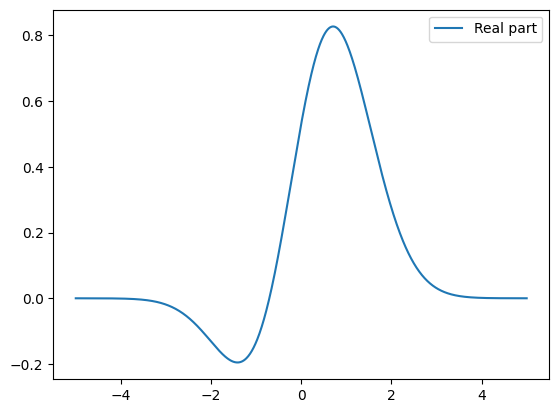

In [2]:
from GKP_functions import fock_coefficients_to_position, fock_to_position
from GKP_functions import fock_density_matrix_to_position # Function to compute the position density matrix from the Fock basis density matrix

# Example Fock coefficients (some arbitrary values)
coeffs = np.array([1/np.sqrt(2), 1/np.sqrt(2)])

# Position grid
q = np.linspace(-5, 5, 1000)

# Get the resulting wavefunction
wavefunction = fock_coefficients_to_position(coeffs, q)

# Plot the real parts of the wavefunction
plt.plot(q, wavefunction.real, label='Real part')
plt.legend()
plt.show()

We define our GKP state, built on from [here](https://github.com/XanaduAI/approximate-GKP-prep/blob/master/Formalism.ipynb). This allows us to get both the position wavefunction, and Fock coefficients of any rectangular GKP qubit. We define the normalised GKP state using a Guassian envelope, e.g. $|\psi_{\triangle}\rangle = e^{-\triangle \hat{n}}|\psi\rangle$, where $\hat{n}$ is the number operator, $\triangle$ is the squeezing parameter in **dB** and $|\psi\rangle$ is the ideal GKP state.

Now let's use bosonic qiskit to initialize a qumode a plot the wigner funciton of the GKP state.

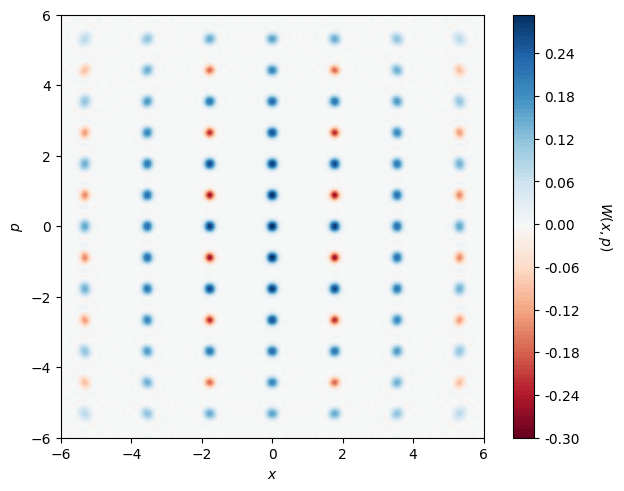

In [3]:
from GKP_functions import gkp_fock_coeff #Returns the nth Fock coefficient for the ideal logical GKP state
from GKP_functions import gkp_fock #Returns the epsilon GKP q wavefunction and coefficients in the Fock basis

# Define the qubit and q values
qubit = np.array([1, 0])
q = np.linspace(-10, 10, 1000)
eps = 0.019
# Generate the GKP state and coefficients
gkp, gkp_coeffs = gkp_fock(qubit, eps, q)


#Initialize circuit
qmr = c2qa.QumodeRegister(
    num_qumodes=1,
    num_qubits_per_qumode=7) #qumode
qbr = qiskit.QuantumRegister(1) #qubit
cr = qiskit.ClassicalRegister(1) #readout bit
sBs_circuit = c2qa.CVCircuit(qmr, qbr, cr) #create circuit

sBs_circuit.cv_initialize(list(gkp_coeffs), qmr[0]) #initialize gkp |0> state
sBs_circuit.h(qbr[0]) # Intialize qubit in |+>

state,_,_ = c2qa.wigner.simulate(sBs_circuit)
plot = c2qa.wigner.plot_wigner(sBs_circuit, state)

### Qunaught state
The square qunaught state is defined as:
$$
|0\rangle_{\text{qunaught}} \propto \sum_{n \in Z} |\hat{q} = n\sqrt{2 \pi}\rangle \propto \sum_{n \in Z} |\hat{p} = n\sqrt{2 \pi}\rangle
$$
The qunaught doesn't carry any logical information.

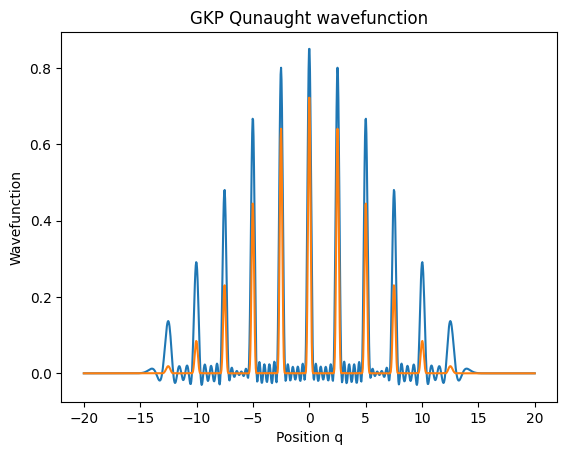

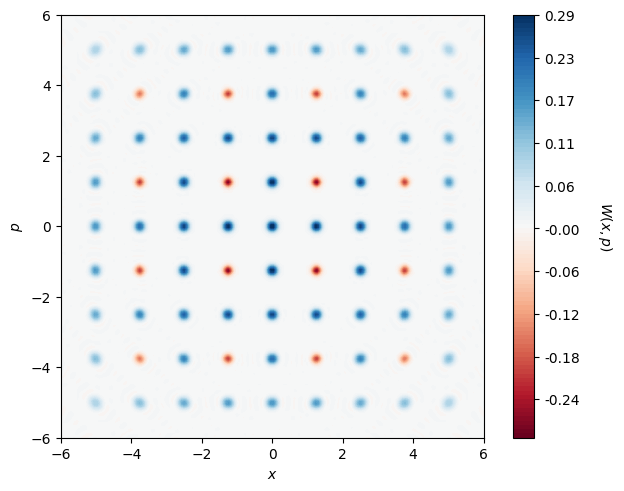

In [4]:
from GKP_functions import qunaught_fock_coeff #Returns the epsilon-qunaught q wavefunction and coefficients in the Fock basis.
from GKP_functions import qunaught_fock #Returns the nth Fock coefficient for the ideal qunaught GKP state.
# Define the q value
q = np.linspace(-20, 20, 1000)
eps =  0.019

# Generate the GKP state and coefficients
qunaught, qunaught_coeffs = qunaught_fock(eps, q, norm = True)

#plot the qunaught wavefunction
plt.plot(q, qunaught)
plt.plot(q, np.abs(qunaught)**2)
plt.title(f'GKP Qunaught wavefunction')
plt.xlabel('Position q')
plt.ylabel('Wavefunction')
plt.show()


# #Initialize circuit
qmr = c2qa.QumodeRegister(
    num_qumodes=1,
    num_qubits_per_qumode=7) #qumode
qbr = qiskit.QuantumRegister(1) #qubit
cr = qiskit.ClassicalRegister(1) #readout bit
qunaught_circuit = c2qa.CVCircuit(qmr, qbr, cr) #create circuit

qunaught_circuit.cv_initialize(list(qunaught_coeffs), qmr[0]) #initialize gkp |0> state
qunaught_circuit.h(qbr[0]) # Intialize qubit in |+>


state,_,_ = c2qa.wigner.simulate(qunaught_circuit)
plot = c2qa.wigner.plot_wigner(qunaught_circuit, state)

# GKP Qunaught State Preperation
This can be done this can be done through dissapative stabilization (sBs, BsB, sharpen-trim), from the vacuum. See figures 8 and 9 [here](https://arxiv.org/abs/2103.06994). The idea is, we are free to choose our target GKP squeezing $\triangle_{dB}$, and we can choose our noise variance based  on this $\triangle$ (argument for displacement operator) according to 
$$
\triangle = \sqrt{\frac{1}{2} 10^{-\triangle_{dB}10}}
$$

### Effective GKP Squeezings
A performance metric for GKP quanught state preperation is the GKP squeezing, which for a state $\hat{\rho}$ is defined as
$$
\triangle_{eff}^{dB} = 10 \log_{10}\left(\frac{1/2}{\log(1/\text{Tr}(\hat{S}_q \hat{\rho}))/\pi}\right)
$$
in the q quadrature (for p quadrature, just switch to the $\hat{S}_p$ stabilizer).
In Bosonic qiskit, we are able to get the reduced density of the cavity in the Fock basis:
```python
# c2qa.util.trace_out_qubits() performs a partial trace over the qubits, giving the reduced density matrix of the cavities
print(c2qa.util.trace_out_qubits(circuit0, state0))
```
Note conditional dispalcements given [here](https://arxiv.org/abs/2103.06994) use a slightly different convention to Bosonic qiskit (and the usual convention), thus all arguments must be multiplied by $-\frac{1}{2\sqrt{2}}$. The arguments for conditionall displacement used for sBs, Bsb

In [5]:
def dissipative_stabilization_parameters(goal_squeezing):
    """
    Calculates the dissipative stabilization parameters for a given goal squeezing in dB.

    Args:
    goal_squeezing (float): The goal squeezing value in decibels (dB).

    Returns:
    tuple: A tuple containing the following calculated parameters:
        - ell_q (complex): IG q parameter
        - eps_q (float): Small q parameter
        - ell_p (float): Big P parameter
        - eps_p (complex): Small p parameter
        - theta (float): Qubit x rotation in radians (π/2)
    """
    # Calculate the triangle parameter
    triangle_parameter = np.sqrt(10 ** (-goal_squeezing / 10) / 2)
    # Calculate ell_q, eps_q, ell_p, and eps_p
    ell_q = 1j * np.sqrt(2 * np.pi) * np.cosh(2 * triangle_parameter**2) * (-1/(2*np.sqrt(2)))   # IG q
    eps_q = np.sqrt(2 * np.pi) * np.sinh(2 * triangle_parameter**2) * (-1/(2*np.sqrt(2)))         # small q
    ell_p = np.sqrt(2 * np.pi) * np.cosh(2 * triangle_parameter**2) * (-1/(2*np.sqrt(2)))         # Big P
    eps_p = -1j * np.sqrt(2 * np.pi) * np.sinh(2 * triangle_parameter**2) * (-1/(2*np.sqrt(2)))   # small p
    
    # Define theta (Qubit x rotation)
    theta = np.pi / 2
    
    # Return the calculated parameters as a tuple
    return ell_q, eps_q, ell_p, eps_p, theta

# Example usage:
ell_q, eps_q, ell_p, eps_p, theta = dissipative_stabilization_parameters(13)

### BIG small BIG

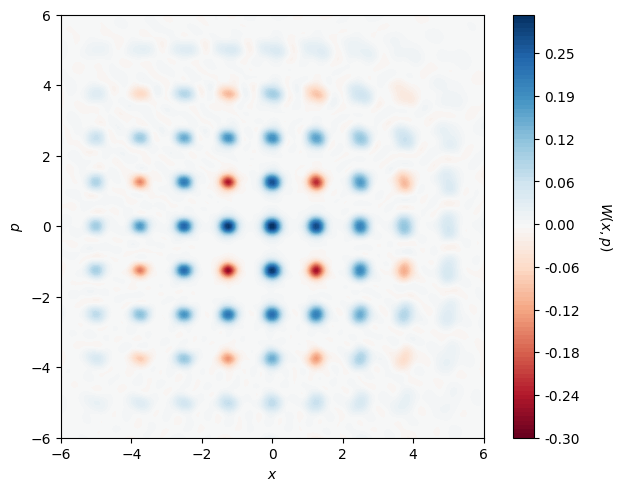

In [6]:
#Initialize the circuit components
qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=6)  # Defines the qumodes
qbr = qiskit.QuantumRegister(1)  # Single qubit register
cr = qiskit.ClassicalRegister(1)  # Classical register for readout
BsB_circuit = c2qa.CVCircuit(qmr, qbr, cr)  # Create the main circuit

# Function to apply the Big-Small-Big sequence
def apply_bsb_sequence(circuit, q_mode, qbit, ell, eps, theta):
    circuit.h(qbit)  # Initialize qubit in |+> state after reset
    circuit.cv_c_d(ell, q_mode, qbit) # First Big Operation (Controlled Displacement
    circuit.rx(theta, qbit)   # Apply Rx rotation
    circuit.cv_c_d(2 * eps, q_mode, qbit)     # Small Operation (Controlled Displacement)
    circuit.rx(-theta, qbit)     # Apply Rx dagger (inverse of Rx)
    circuit.cv_c_d(ell, q_mode, qbit) # Second Big Operation (Controlled Displacement)
    circuit.reset(qbit) # Reset qubit to complete the cycle


# Loop through the sequence
for _ in range(10):
    apply_bsb_sequence(BsB_circuit, qmr[0], qbr[0], ell_q, eps_q, theta)  # BsB q
    apply_bsb_sequence(BsB_circuit, qmr[0], qbr[0], ell_p, eps_p, theta)  # BsB p

# Simulate and plot Wigner function
BsB_state, _, _ = c2qa.wigner.simulate(BsB_circuit)
plot = c2qa.wigner.plot_wigner(BsB_circuit, BsB_state)

Now we can extract the reduced density matrix of the system and calculate the effective squeezing. 

In [7]:
from GKP_functions import compute_Delta_eff_dB_q
BsB_density_matrix = np.array(c2qa.util.trace_out_qubits(BsB_circuit, BsB_state))

# Compute Δ_eff^{dB}
Delta_eff_dB = compute_Delta_eff_dB_q(BsB_density_matrix)

print("Δ_eff^{dB} for 10 rounds of BsB=", Delta_eff_dB)

Δ_eff^{dB} for 10 rounds of BsB= 11.73314401235588


### small BIG small

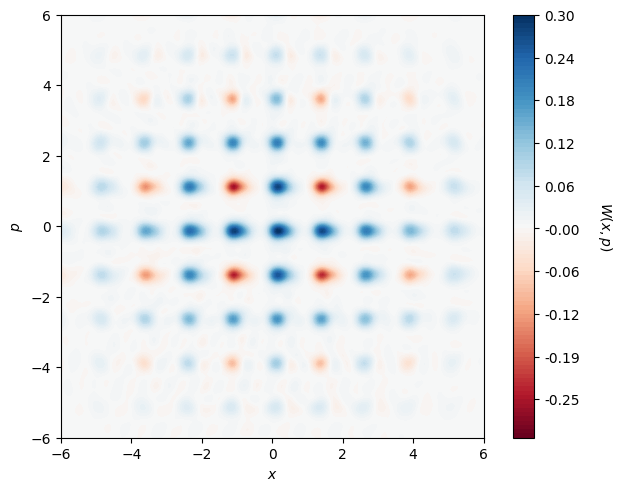

In [8]:
# Step 1: Initialize the circuit components
qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=6)  # Defines the qumodes
qbr = qiskit.QuantumRegister(1)  # Single qubit register
sBs_circuit = c2qa.CVCircuit(qmr, qbr)  # Create the main circuit

# Function to apply the sBs sequence for q and p
def apply_sbs_sequence(circuit, q_mode, qbit, ell, eps, theta):
    circuit.h(qbit)  ## Initialize qubit in the |+> state
    circuit.cv_c_d(eps / 2, q_mode, qbit)  ## SMALL operation
    circuit.rx(-theta, qbit)  ## Qubit rotation Rx(-theta)
    circuit.cv_c_d(ell, q_mode, qbit)  ## BIG operation
    circuit.rx(theta, qbit)  ## Qubit rotation Rx(theta)
    circuit.cv_c_d(eps / 2, q_mode, qbit)  ## SMALL operation
    circuit.reset(qbit)  ## Reset the qubit to complete the cycle

# Loop through the sequence
for _ in range(10):
    for _ in range(2):
        apply_sbs_sequence(sBs_circuit, qmr[0], qbr[0], ell_q, eps_q, theta)  ## Apply q mode sequence
    for _ in range(2):
        apply_sbs_sequence(sBs_circuit, qmr[0], qbr[0], ell_p, eps_p, theta)  ## Apply p mode sequence

# Simulate and plot Wigner function
sBs_state, _, _ = c2qa.wigner.simulate(sBs_circuit)
plot = c2qa.wigner.plot_wigner(sBs_circuit, sBs_state)

In [9]:
sBs_density_matrix = np.array(c2qa.util.trace_out_qubits(sBs_circuit, sBs_state))

# Compute Δ_eff^{dB}
Delta_eff_dB = compute_Delta_eff_dB_q(sBs_density_matrix)

print("Δ_eff^{dB} for 10 rounds of sBs=", Delta_eff_dB)

Δ_eff^{dB} for 10 rounds of sBs= 10.268443823188091


### Sharpen Trim

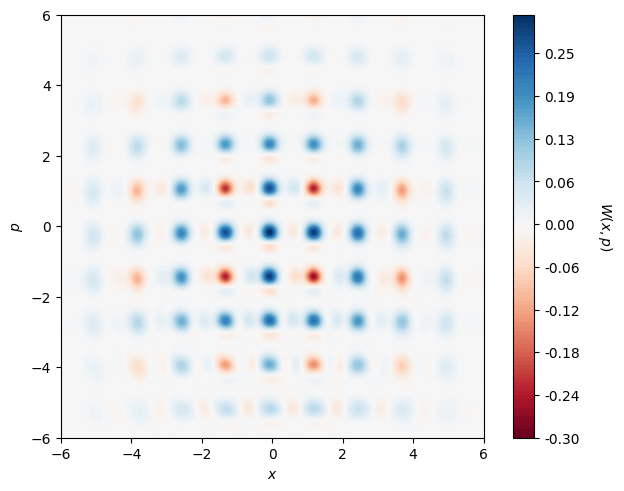

In [10]:
# Initialize the circuit components
qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=6)  # Defines the qumodes
qbr = qiskit.QuantumRegister(1)  # Single qubit register
sharpen_trim_circuit = c2qa.CVCircuit(qmr, qbr)  # Create the main circuit

# Function to apply the sharpen sequence for q and p
def apply_sharpen_sequence(circuit, q_mode, qbit, ell, eps, theta):
    circuit.h(qbit)  ## Initialize qubit in the |+> state
    circuit.cv_c_d(ell, q_mode, qbit)  ## big operation
    circuit.rx(theta, qbit)
    circuit.cv_c_d(eps, q_mode, qbit)  ## SMALL operation
    circuit.reset(qbit)

def apply_trim_sequence(circuit, q_mode, qbit, ell, eps, theta):
    circuit.h(qbit)  ## Initialize qubit in the |+> state
    circuit.cv_c_d(eps, q_mode, qbit)  ## SMALL operation
    circuit.rx(-theta, qbit) #rx dagger
    circuit.cv_c_d(ell, q_mode, qbit)  ## big operation
    circuit.reset(qbit)

# Loop through the sequence
for _ in range(10):
    #Sharpen trim q
    apply_sharpen_sequence(sharpen_trim_circuit, qmr[0], qbr[0], ell_q, eps_q, theta)  ## sharpen
    apply_trim_sequence(sharpen_trim_circuit, qmr[0], qbr[0], ell_q, eps_q, theta)  ## trim

    #Sharpen trim p
    apply_sharpen_sequence(sharpen_trim_circuit, qmr[0], qbr[0], ell_p, eps_p, theta)  ## sharpen
    apply_trim_sequence(sharpen_trim_circuit, qmr[0], qbr[0], ell_p, eps_p, theta)  ## trim    

# Simulate and plot Wigner function
sharpen_trim_state, _, _ = c2qa.wigner.simulate(sharpen_trim_circuit)
plot = c2qa.wigner.plot_wigner(sharpen_trim_circuit, sharpen_trim_state)

In [11]:
sharpen_trim_density_matrix = np.array(c2qa.util.trace_out_qubits(sharpen_trim_circuit, sharpen_trim_state))

# Compute Δ_eff^{dB}
Delta_eff_dB = compute_Delta_eff_dB_q(sharpen_trim_density_matrix)

print("Δ_eff^{dB} for 10 rounds of sBs=", Delta_eff_dB)

Δ_eff^{dB} for 10 rounds of sBs= 11.286282378346485


### Effective GKP Squeezings
A performance metric for GKP quanught state preperation is the GKP squeezing, which for a state $\hat{\rho}$ is defined as
$$
\triangle_{eff}^{dB} = 10 \log_{10}\left(\frac{1/2}{\log(1/\text{Tr}(\hat{S}_q \hat{\rho}))/\pi}\right)
$$
in the q quadrature (for p quadrature, just switch to the $\hat{S}_p$ stabilizer).
In Bosonic qiskit, we are able to get the reduced density of the cavity in the Fock basis:
```python
# c2qa.util.trace_out_qubits() performs a partial trace over the qubits, giving the reduced density matrix of the cavities
c2qa.util.trace_out_qubits(circuit0, state0)
```

First, for a fixed target squeezing of $13 dB$, let's plot the achieved squeezing against the number of rounds for each protocol.

In [12]:
from GKP_functions import run__qunaught_prep_circuit
import time

# List of methods and markers for plotting
methods = ['BsB', 'sBs', 'Sharpen Trim']
markers = {'BsB': 'o', 'sBs': 's', 'Sharpen Trim': '^'}

#Define parameters for disspiative stabilization
goal_squeezing = 13  # Goal squeezing in dB
num_qubits_per_mode = 7
# Example usage:
ell_q, eps_q, ell_p, eps_p, theta = dissipative_stabilization_parameters(goal_squeezing)

# Dictionary to store Delta_eff_dB for each method
Delta_eff_dB = {method: [] for method in methods}

rounds_list = list(range(0, 31, 5))

start = time.time()

for i in rounds_list:
    for method in methods:
        Delta_eff = run__qunaught_prep_circuit(method, i, ell_q, eps_q, ell_p, eps_p, theta, num_qubits_per_mode)
        Delta_eff_dB[method].append(Delta_eff)

end = time.time()

print("Time taken:", end - start)

Time taken: 869.3550889492035


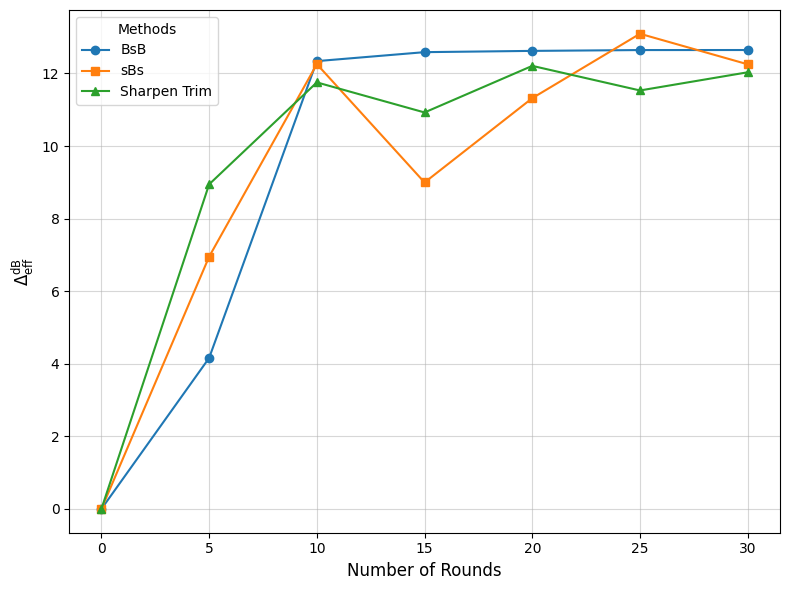

In [ ]:
plt.figure(figsize=(8, 6))

for method in methods:
    plt.plot(rounds_list, Delta_eff_dB[method], marker=markers[method], label=method)

plt.xlabel("Number of Rounds", fontsize=12)
plt.ylabel(r"$\Delta_{\mathrm{eff}}^{\mathrm{dB}}$", fontsize=12)

plt.grid(alpha=0.5)
plt.legend(title="Methods", fontsize=10)
plt.tight_layout()

# Show the updated plot
plt.show()

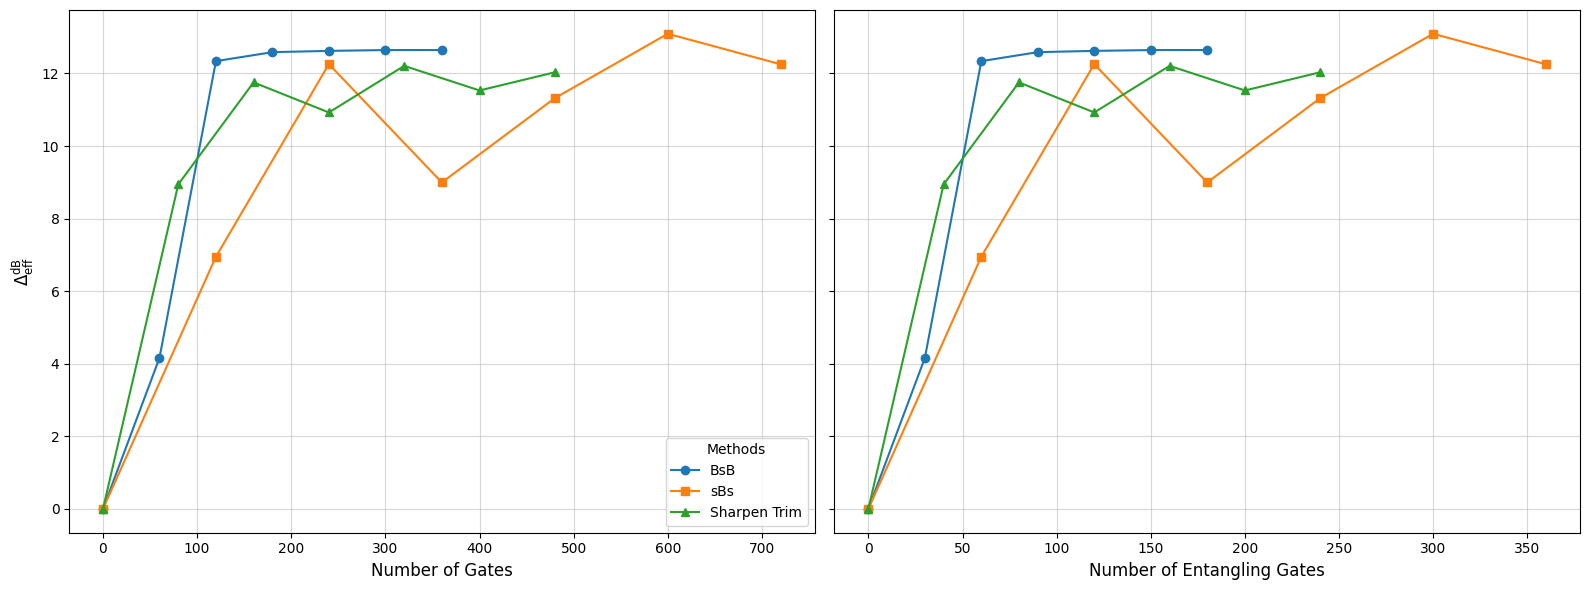

In [18]:
# Number of gates per round
gates_per_round = {
    'BsB': 6*2,  
    'sBs': 6*2*2,  
    'Sharpen Trim': 4*4
}

# Number of qubit-mode entangling gates (cv_c_d) per round
entangling_gates_per_round = {
    'BsB': 3 * 2,  
    'sBs': 3 * 2 * 2,  
    'Sharpen Trim': 2 * 4  
}

# Calculate the total number of gates and entangling gates for each method
total_gates = {method: [rounds * gates_per_round[method] for rounds in rounds_list] for method in methods}
total_entangling_gates = {method: [rounds * entangling_gates_per_round[method] for rounds in rounds_list] for method in methods}

markers = {'BsB': 'o', 'sBs': 's', 'Sharpen Trim': '^'}

# Create subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot achieved squeezing vs total number of gates
for method in methods:
    axs[0].plot(total_gates[method], Delta_eff_dB[method], marker=markers[method], label=method)
axs[0].set_xlabel("Number of Gates", fontsize=12)
axs[0].set_ylabel(r"$\Delta_{\mathrm{eff}}^{\mathrm{dB}}$", fontsize=12)
axs[0].grid(alpha=0.5)
axs[0].legend(title="Methods", fontsize=10)

# Plot achieved squeezing vs total number of entangling gates
for method in methods:
    axs[1].plot(total_entangling_gates[method], Delta_eff_dB[method], marker=markers[method], label=method)
axs[1].set_xlabel("Number of Entangling Gates", fontsize=12)
axs[1].grid(alpha=0.5)

plt.tight_layout()

plt.show()